### Step 1: Import Libraries
In this step, we import all the required libraries for building, training, and evaluating our machine learning model. These libraries include `torch` and `torchvision` for deep learning, `timm` for the ConvNeXt model, and additional libraries for data processing, visualization, and metrics.


In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import timm
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from kaggle.api.kaggle_api_extended import KaggleApi
import zipfile

C:\Users\Abang Sano\miniconda3\envs\picture_classification\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Step 2: Download Dataset with Kaggle API
We use the Kaggle API to download the gender classification dataset directly into our project folder. This step includes authenticating with the Kaggle API, downloading the dataset, and extracting it. This makes it easy to integrate the dataset directly into our training pipeline without manual downloads.


In [2]:
# Step 1: Download the Dataset Using Kaggle API
# Initialize and authenticate the Kaggle API
api = KaggleApi()
api.authenticate()

In [3]:
# Specify the download path
dataset_path = 'dataset'
if not os.path.exists(dataset_path):
    os.makedirs(dataset_path)

# Check if dataset is already downloaded
dataset_files = ['Testing', 'Training']  # Expected folders in the dataset
dataset_already_downloaded = all(os.path.exists(os.path.join(dataset_path, folder)) for folder in dataset_files)

if not dataset_already_downloaded:
    print("Dataset not found locally. Downloading now...")
    # Download the dataset
    api.dataset_download_files('cashutosh/gender-classification-dataset', path=dataset_path, unzip=True)
    
    # Remove the zip file if it exists
    zip_file = os.path.join(dataset_path, 'gender-classification-dataset.zip')
    if os.path.exists(zip_file):
        os.remove(zip_file)
else:
    print("Dataset already exists locally. Skipping download.")

Dataset not found locally. Downloading now...
Dataset URL: https://www.kaggle.com/datasets/cashutosh/gender-classification-dataset


### Step 3: Data Preprocessing
Data preprocessing is a crucial step where we define transformations to prepare the images for input into our model. This involves resizing the images to the required size and normalizing them using mean and standard deviation values suitable for pre-trained models. We also load the dataset into a PyTorch-compatible format and split it into training and validation sets.


In [4]:
# Step 2: Data Preprocessing
# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [5]:
# Load the dataset
train_dataset = datasets.ImageFolder(root=os.path.join(dataset_path, 'Training'), transform=transform)
test_dataset = datasets.ImageFolder(root=os.path.join(dataset_path, 'Validation'), transform=transform)

In [6]:
# Combine training and testing datasets (optional, if you want to split differently)
full_dataset = train_dataset + test_dataset

In [7]:
# Split the dataset into training and validation sets
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

In [8]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

In [9]:
class_names = ['female', 'male']

### Step 4: Load ConvNeXt V2 Model
In this step, we load the pre-trained ConvNeXt V2 model using the `timm` library. We replace the last layer (classifier) of the model with a new layer that matches the number of output classes (`female` and `male`). This is called "fine-tuning", where we adapt a general model to our specific task.

In [10]:
# Step 3: Load the ConvNeXt V2 Model
# Check if CUDA is available and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
import timm

# List available ConvNeXt V2 models
models = timm.list_models('convnextv2*')
print(models)


['convnextv2_atto', 'convnextv2_base', 'convnextv2_femto', 'convnextv2_huge', 'convnextv2_large', 'convnextv2_nano', 'convnextv2_pico', 'convnextv2_small', 'convnextv2_tiny']


In [13]:
# Load ConvNeXt V2 model
model = timm.create_model('convnextv2_atto', pretrained=True)
num_features = model.head.fc.in_features  # Access the in_features of the classifier
model.head.fc = nn.Linear(num_features, len(class_names))  # Replace with new classifier
model.to(device)

ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 40, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((40,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(40, 40, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=40)
          (norm): LayerNorm2d((40,), eps=1e-06, elementwise_affine=True)
          (mlp): GlobalResponseNormMlp(
            (fc1): Conv2d(40, 160, kernel_size=(1, 1), stride=(1, 1))
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (grn): GlobalResponseNorm()
            (fc2): Conv2d(160, 40, kernel_size=(1, 1), stride=(1, 1))
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (shortcut): Identity()
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(40, 40, kernel_size=(7, 7), stride=(1, 1), 

### Step 5: Define Loss Function and Optimizer
Here, we define the loss function and the optimizer for training our model. The loss function used is Cross Entropy Loss, which is suitable for multi-class classification tasks. We use the Adam optimizer to update the model parameters based on the gradients computed during backpropagation.


In [14]:
# Step 4: Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

### Step 6: Training and Validation Loop
This is the core part of our model training. We train our model over multiple epochs, using a training loop to adjust the model weights and a validation loop to evaluate its performance. After each epoch, we compute performance metrics, including accuracy, precision, and recall, to understand how well our model is learning.

In [15]:
# Step 5: Training and Evaluation Loop
num_epochs = 10

Epoch [1/10], Loss: 0.1102
Validation Accuracy: 96.59%
Precision: 0.99
Recall: 0.95
              precision    recall  f1-score   support

      female       0.95      0.99      0.97      5779
        male       0.99      0.95      0.97      5953

    accuracy                           0.97     11732
   macro avg       0.97      0.97      0.97     11732
weighted avg       0.97      0.97      0.97     11732



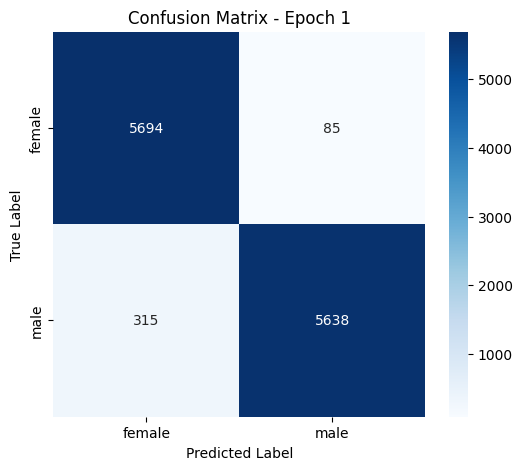

Epoch [2/10], Loss: 0.0729
Validation Accuracy: 96.67%
Precision: 0.97
Recall: 0.96
              precision    recall  f1-score   support

      female       0.96      0.97      0.97      5779
        male       0.97      0.96      0.97      5953

    accuracy                           0.97     11732
   macro avg       0.97      0.97      0.97     11732
weighted avg       0.97      0.97      0.97     11732



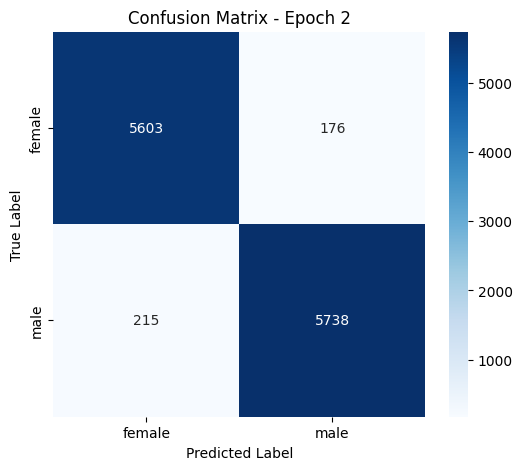

Epoch [3/10], Loss: 0.0599
Validation Accuracy: 97.18%
Precision: 0.97
Recall: 0.97
              precision    recall  f1-score   support

      female       0.97      0.97      0.97      5779
        male       0.97      0.97      0.97      5953

    accuracy                           0.97     11732
   macro avg       0.97      0.97      0.97     11732
weighted avg       0.97      0.97      0.97     11732



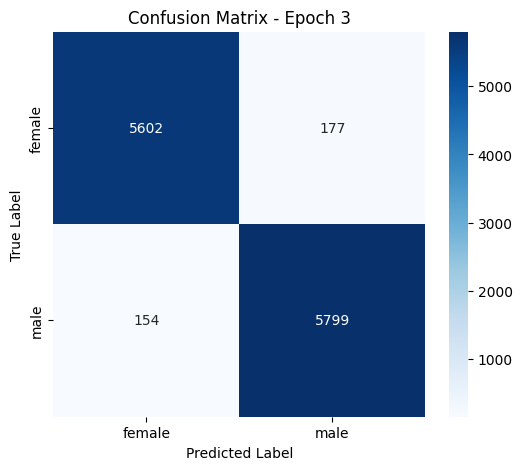

Epoch [4/10], Loss: 0.0459
Validation Accuracy: 95.42%
Precision: 0.99
Recall: 0.92
              precision    recall  f1-score   support

      female       0.92      0.99      0.96      5779
        male       0.99      0.92      0.95      5953

    accuracy                           0.95     11732
   macro avg       0.96      0.95      0.95     11732
weighted avg       0.96      0.95      0.95     11732



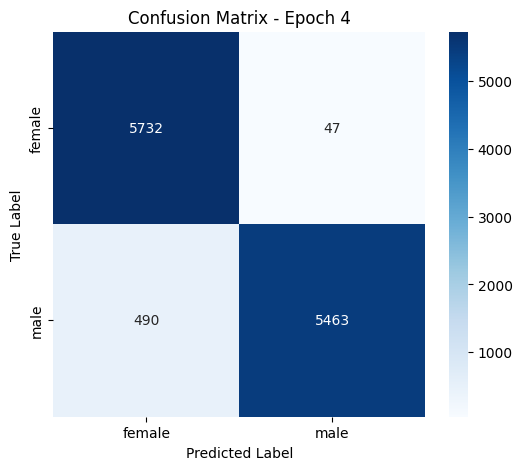

Epoch [5/10], Loss: 0.0356
Validation Accuracy: 96.76%
Precision: 0.97
Recall: 0.97
              precision    recall  f1-score   support

      female       0.97      0.97      0.97      5779
        male       0.97      0.97      0.97      5953

    accuracy                           0.97     11732
   macro avg       0.97      0.97      0.97     11732
weighted avg       0.97      0.97      0.97     11732



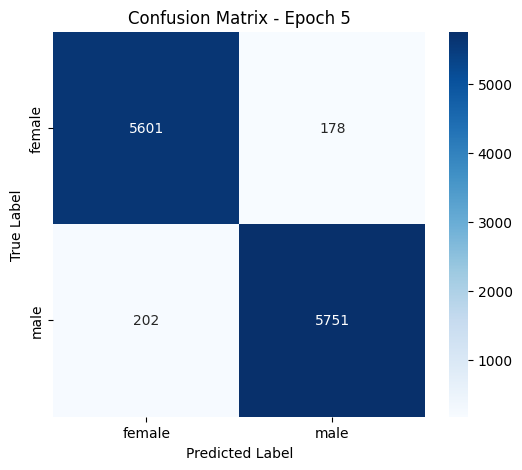

Epoch [6/10], Loss: 0.0248
Validation Accuracy: 96.35%
Precision: 0.98
Recall: 0.94
              precision    recall  f1-score   support

      female       0.95      0.98      0.96      5779
        male       0.98      0.94      0.96      5953

    accuracy                           0.96     11732
   macro avg       0.96      0.96      0.96     11732
weighted avg       0.96      0.96      0.96     11732



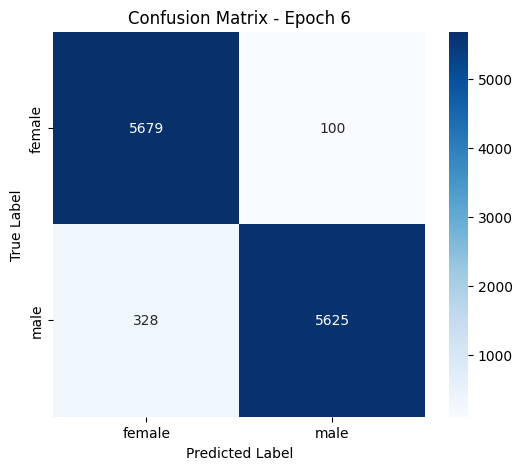

Epoch [7/10], Loss: 0.0212
Validation Accuracy: 96.82%
Precision: 0.97
Recall: 0.97
              precision    recall  f1-score   support

      female       0.97      0.97      0.97      5779
        male       0.97      0.97      0.97      5953

    accuracy                           0.97     11732
   macro avg       0.97      0.97      0.97     11732
weighted avg       0.97      0.97      0.97     11732



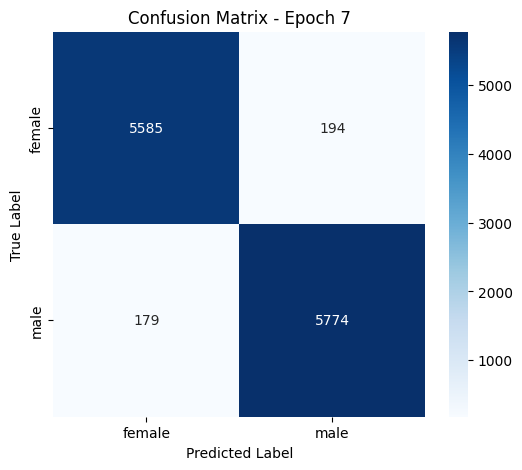

Epoch [8/10], Loss: 0.0179
Validation Accuracy: 96.45%
Precision: 0.99
Recall: 0.94
              precision    recall  f1-score   support

      female       0.94      0.99      0.96      5779
        male       0.99      0.94      0.96      5953

    accuracy                           0.96     11732
   macro avg       0.97      0.96      0.96     11732
weighted avg       0.97      0.96      0.96     11732



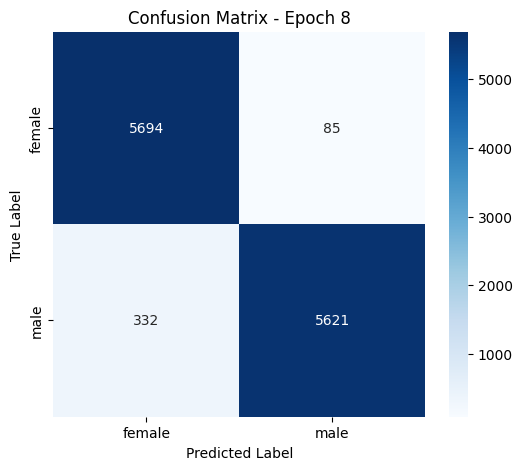

Epoch [9/10], Loss: 0.0139
Validation Accuracy: 97.17%
Precision: 0.97
Recall: 0.97
              precision    recall  f1-score   support

      female       0.97      0.97      0.97      5779
        male       0.97      0.97      0.97      5953

    accuracy                           0.97     11732
   macro avg       0.97      0.97      0.97     11732
weighted avg       0.97      0.97      0.97     11732



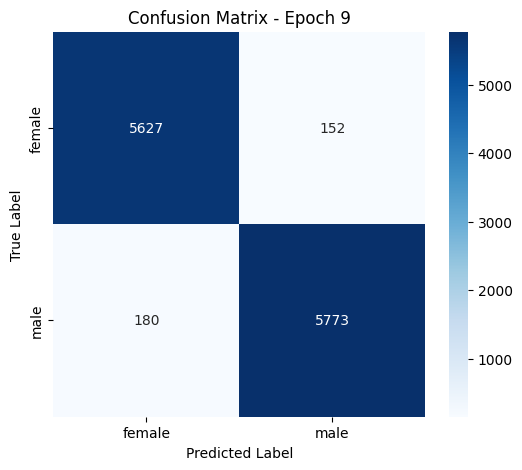

Epoch [10/10], Loss: 0.0119
Validation Accuracy: 96.95%
Precision: 0.98
Recall: 0.96
              precision    recall  f1-score   support

      female       0.96      0.98      0.97      5779
        male       0.98      0.96      0.97      5953

    accuracy                           0.97     11732
   macro avg       0.97      0.97      0.97     11732
weighted avg       0.97      0.97      0.97     11732



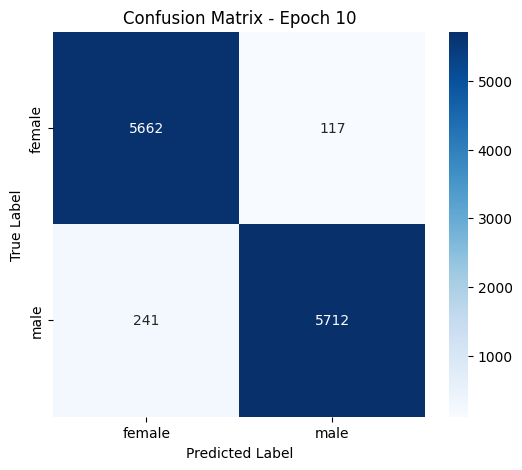

In [16]:
for epoch in range(num_epochs):
    # Training Phase
    model.train()
    total_loss = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    # Validation Phase
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='binary', pos_label=1)
    recall = recall_score(all_labels, all_preds, average='binary', pos_label=1)

    print(f'Validation Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')

    # Classification report
    report = classification_report(all_labels, all_preds, target_names=class_names)
    print(report)

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - Epoch {epoch+1}')
    plt.show()

In [ ]:
# Step 6: Save the Trained Model
#torch.save(model.state_dict(), 'gender_classification_model.pth')